In [126]:
# default_exp data.external

In [127]:
# hide
import sys

sys.path.append("..")
import pandas as pd

# Data Collection

> Adding the M4 data to the fastai way of storing/downloading data.

Datasets to incl:

- [x] m4 daily
- [ ] gunpoint
- [ ] Phoneme <http://www.timeseriesclassification.com/description.php?Dataset=Phoneme>
- [ ] Worms <http://www.timeseriesclassification.com/description.php?Dataset=Worms>
- [ ] BeetleFly <http://www.timeseriesclassification.com/description.php?Dataset=BeetleFly>
- [ ] m4 hourly
- [ ] M5 

using zip files
https://forums.fast.ai/t/generalizing-untar-data-to-also-work-with-zips/53741/14?u=takotab

In [128]:
# export
from fastseq.core import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
import pandas as pd

## M4 daily

In [129]:
# hide
URLs.IMAGEWOOF

'https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2.tgz'

In [130]:
# hide
path = untar_data(URLs.IMAGEWOOF)

In [131]:
# hide
path.ls()

(#2) [Path('/home/tako/.fastai/data/imagewoof2/val'),Path('/home/tako/.fastai/data/imagewoof2/train')]

In [132]:
# export
m4_base = "https://motionnet-m4-dataset.s3.eu-central-1.amazonaws.com/"
URLs.m4_daily = f'{m4_base}m4_daily.tgz'

In [133]:
URLs.m4_daily

'https://motionnet-m4-dataset.s3.eu-central-1.amazonaws.com/m4_daily.tgz'

In [134]:
# hide
try:
    os.remove(URLs.path(URLs.m4_daily))
except:
    pass
path = untar_data(URLs.m4_daily)

In [135]:
# hide
test_eq(len(path.ls()),2)
path.ls()

(#2) [Path('/home/tako/.fastai/data/m4_daily/train.csv'),Path('/home/tako/.fastai/data/m4_daily/val.csv')]

## dummy

In [136]:
# export 
def dummy_data_generator(lookback:int, horizon:int, signal_type='seasonality', nrows:int=5, random = True, batch_size=32, norm=False, noise = .2):
    def get_datapoint():
        lin_space = np.linspace(-lookback, horizon, lookback + horizon)
        if random:
            offset = np.random.standard_normal() * .10
        else:
            offset = 1            
        if signal_type == 'lin':
            a =  np.random.standard_normal() * lin_space + offset * 100
        
        a = np.zeros_like(lin_space)            
        if signal_type is not 'seasonality':
            p = 4
            a = [(lin_space**(i))[None,:] for i in range(p)]
            T = np.concatenate(a)
            thetas = np.random.randn(4)*1*9**-p
            a= np.matmul(thetas,T) 
            
        if signal_type is not 'trend':
            a += np.cos(2 * np.random.randint(low=1, high=3) * np.pi * lin_space)* np.random.standard_normal() * .5
            a += np.cos(2 * np.random.randint(low=2, high=4) * np.pi * lin_space)* np.random.standard_normal() * .5
            a += np.sin(2 * np.random.randint(low=1, high=3) * np.pi * lin_space)
            a -= np.sin(2 * np.random.randint(low=2, high=4) * np.pi * lin_space)
            a += lin_space * offset + np.random.rand() * 10
            
        a += np.random.randn(a.shape[0])*noise
        if norm:
            return (a[None,:]-a.mean())/a.std()
        else:
            return a[None,:]
    
    data = L()
    for i in range(nrows):
        data.append(get_datapoint())        
        
    return data


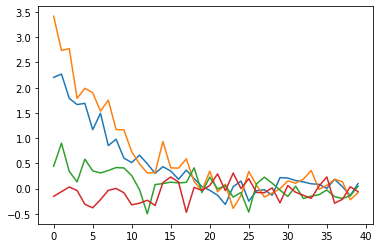

In [137]:
r = dummy_data_generator(30,10,signal_type='trend')
plt.plot(r[0][0,:])
plt.plot(r[1][0,:])
plt.plot(r[2][0,:])
plt.plot(r[3][0,:])

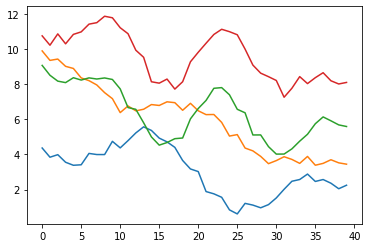

In [138]:
r = dummy_data_generator(30,10)
plt.plot(r[0][0,:])
plt.plot(r[1][0,:])
plt.plot(r[2][0,:])
plt.plot(r[3][0,:])

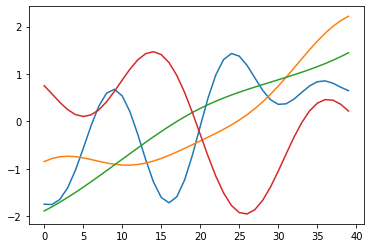

In [139]:
r = dummy_data_generator(30,10,norm=True, noise = 0)
plt.plot(r[0][0,:])
plt.plot(r[1][0,:])
plt.plot(r[2][0,:])
plt.plot(r[3][0,:])

# Multivariate

## easy

In [140]:
# export
def dummy_generator_multi_easy(length, signal_type='none',nrows:int=5, random = True, noise = .3,
                               norm = True, norm_t = True, increase_noise = False, rang = [5,5]):

    data = L() 
    for i in range(nrows):
        weather = dummy_data_generator(length-10, 10, signal_type = 'seasonality', nrows=1, random=random, noise = 0 )[0]
        n = (1+np.random.randn(length) * np.arange(0,10*length, 10) * .001 * noise)[None,:]
        final = (rang[0] + np.random.sample()*(rang[1]-rang[0])) * weather * n
        if norm:
            final = (final-final.mean())/final.std()
        if norm_t:
            weather = (weather-weather.mean())/weather.std()            
        tot = {'x':final,'weather': weather}
        data.append(tot)           
        
    return pd.DataFrame(data)

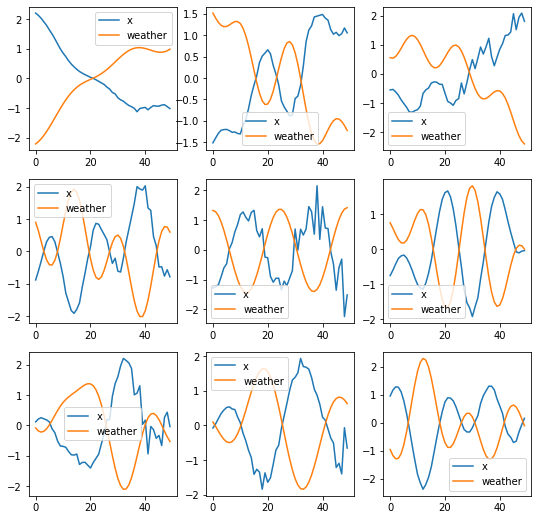

In [141]:
from fastai2.vision.data import get_grid
df = dummy_generator_multi_easy(50,nrows=9, noise = .1, rang=[-1,0])

ctxs = get_grid(len(df))
for i, ctx in enumerate(ctxs):
    for k in ['x', 'weather', 'n']:
        if k in df:      
            ctx.plot(df[k][i][0,:], label= k)
    ctx.legend()

## Hard

In [142]:
# export 

def dummy_data_generator_multi(length, citys=2, cont = False, signal_type='none',nrows:int=5, random = True, noise = .2, incl_city_trend = False, norm= True, increase_noise = False):
    city_names=['adam','rdam','zdam','istanbul','berlin','barcalona','NYC','LA']
    data = L()
    for city_i in range(citys):
        city_trend = dummy_data_generator(length//2, length//2, signal_type = 'trend', nrows=1, random=random, noise = 0 )[0]  
        for i in range(nrows):
            if noise > .15:
                weather = dummy_data_generator(length//2, 0, signal_type = 'seasonality', nrows=1, random=random, noise = 0 )[0]
                weather = np.concatenate([weather,weather],-1)
            else:
                weather = dummy_data_generator(length-10, 10, signal_type = 'seasonality', nrows=1, random=random, noise = 0 )[0]
                
            cont = np.random.randn()
            if cont: 
                city_weather = cont * city_trend + weather
            else:
                city_weather = city_trend + weather
            normal_signal = 3 * dummy_data_generator(length//2, length//2, signal_type = signal_type, nrows=1, random=random, noise = noise )[0]                 
            if increase_noise:
                city_weather += dummy_data_generator(2, length-2, signal_type = 'seasonality', nrows=1, random=random, noise = noise,norm=True )[0] * (np.random.randn(length) *(np.arange(length) * (1/length) ) * noise)
            final = normal_signal + city_weather * (1+np.random.randn(length) * .1 * noise)
            if norm:
                final = (final-final.mean())/final.std()
            tot = {'x': final,'weather': weather,'city': city_names[city_i]}
            if incl_city_trend:
                tot['city_trend']=city_trend
            if cont:
                tot['cont'] = cont
            data.append(tot)           
        
    return pd.DataFrame(data)

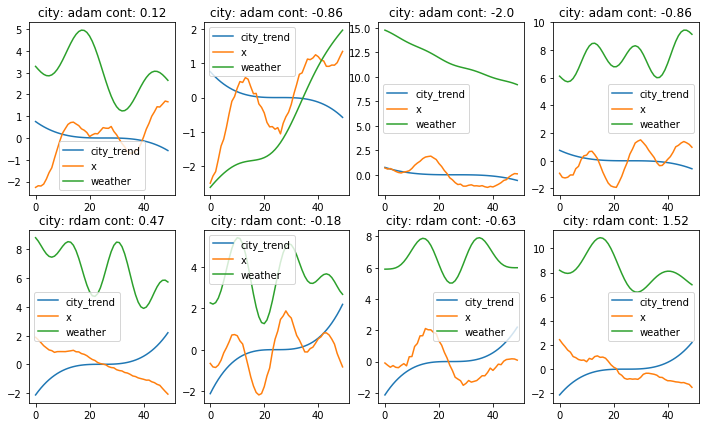

In [143]:
from fastai2.vision.data import get_grid
df = dummy_data_generator_multi(50, nrows = 4, noise = .1, incl_city_trend = True, cont = True)

ctxs = get_grid(len(df), rows=2, cols=4, add_vert=1)
for i, ctx in enumerate(ctxs):
    for k in ['city_trend', 'x', 'weather']:
        if k in df:      
            ctx.plot(df[k][i][0,:], label= k)
    ctx.set_title(f"city: {str(df['city'][i])} cont: {str(np.round(df['cont'][i],2))}")
    ctx.legend()

## Data saving and restoring from json

In [144]:
# export
import numpy as np
import pandas as pd
import orjson

In [145]:
# export
class TSMulti(MultiTuple):pass

In [150]:
# export
def get_df(length = [100,120], use_str = True, classes = {}):
    dct = {'x':[],'con_ts_1':[],'con_ts_0':[],'cat_ts_1':[],'cat_ts_0':[],'con_0':[],'con_1':[], 'cat_0':[],'cat_1':[]}
    for i, l in enumerate(length):
#         assert int(l/2) == l/2
        dct['x'].append(np.arange(l))
        dct['con_ts_0'].append(np.arange(l)[None,:])
        dct['con_ts_1'].append(pd.Series(np.arange(l)+np.random.randn(l)))
        dct['con_0'].append(np.random.rand()*2-1)
        dct['con_1'].append(10+np.random.rand()*2)       
        if 'cat_ts_0' in classes:
            lst = classes['cat_ts_0']
        else:
            lst = ['a','b'] if use_str else [0,1]
        dct['cat_ts_0'].append([random.choice(lst) for _ in range(l)])  
        if 'cat_ts_1' in classes:
            lst = classes['cat_ts_1']
        else:            
            lst = ['david','john'] if use_str else [0,1]
        dct['cat_ts_1'].append([random.choice(lst) for _ in range(l)])  
        if 'cat_0' in classes:
            lst = classes['cat_0']
        else:            
            lst = ['a','b'] if use_str else [0,1]
        dct['cat_0'].append(random.choice(lst))  
        if 'cat_1' in classes:
            lst = classes['cat_1']
        else:                   
            lst = ['adam','rdam'] if use_str else [0,1]
        dct['cat_1'].append(random.choice(lst) )  
    return pd.DataFrame(data=dct)   

In [151]:
# hide 
df = get_df([10,12,6], False)
df

,x,con_ts_1,con_ts_0,cat_ts_1,cat_ts_0,con_0,con_1,cat_0,cat_1
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0 0.852208 1 0.652685 2 2.202536 3 3.432563 4 3.445111 5 3.497823 6 4.521650 7 6.624029 8 7.626167 9 7.966447 dtype: float64,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]","[0, 0, 0, 0, 1, 0, 0, 1, 0, 1]","[1, 1, 1, 1, 1, 0, 0, 0, 1, 1]",0.494317,10.649196,1,0
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",0 -0.105933 1 0.389680 2 3.232725 3 4.678171 4 4.663185 5 5.724986 6 6.962442 7 6.226308 8 8.457998 9 7.368544 10 10.119388 11 12.104481 dtype: float64,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]","[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0]","[0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0]",-0.425847,10.023958,1,0
2,"[0, 1, 2, 3, 4, 5]",0 -0.336128 1 0.998226 2 2.586566 3 1.493060 4 3.195168 5 3.589861 dtype: float64,"[[0, 1, 2, 3, 4, 5]]","[1, 0, 0, 0, 0, 0]","[1, 1, 1, 0, 1, 0]",-0.617836,10.229823,0,1


In [152]:
df = get_df([10,12,6])
df

,x,con_ts_1,con_ts_0,cat_ts_1,cat_ts_0,con_0,con_1,cat_0,cat_1
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0 -0.890727 1 1.263451 2 2.755764 3 4.033591 4 3.960806 5 5.424826 6 6.710796 7 6.131107 8 7.918162 9 9.819636 dtype: float64,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]","[david, john, david, john, john, david, david, david, john, john]","[a, a, a, a, a, b, b, b, a, a]",0.079274,10.159677,b,rdam
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",0 0.212396 1 -0.629102 2 2.142647 3 4.651952 4 3.826377 5 3.872164 6 5.199823 7 6.099096 8 8.454001 9 8.628482 10 9.141597 11 11.133542 dtype: float64,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]","[john, david, david, david, david, david, david, john, david, david, john, david]","[b, b, a, a, b, a, b, b, b, b, b, a]",0.763291,11.309863,a,adam
2,"[0, 1, 2, 3, 4, 5]",0 0.048761 1 2.521193 2 0.319806 3 3.343656 4 3.320062 5 6.342632 dtype: float64,"[[0, 1, 2, 3, 4, 5]]","[david, david, david, david, david, john]","[a, a, b, a, a, a]",0.540265,11.434054,a,adam


In [153]:
df = get_df([5,3,5],classes={'cat_0':['a','b','c'],
                               'cat_ts_1':['john','david','johan','denis'],
                              'cat_ts_0':['ab','bb','ba','c','dd']})
df

,x,con_ts_1,con_ts_0,cat_ts_1,cat_ts_0,con_0,con_1,cat_0,cat_1
0,"[0, 1, 2, 3, 4]",0 -0.223154 1 1.451383 2 1.730716 3 3.539067 4 4.689705 dtype: float64,"[[0, 1, 2, 3, 4]]","[denis, johan, denis, david, johan]","[ab, ab, c, bb, ab]",-0.469569,10.475703,a,adam
1,"[0, 1, 2]",0 -1.629708 1 0.917983 2 3.627175 dtype: float64,"[[0, 1, 2]]","[denis, denis, johan]","[ab, c, c]",0.688105,11.583352,b,rdam
2,"[0, 1, 2, 3, 4]",0 -0.649663 1 0.600140 2 1.906137 3 3.496506 4 3.764853 dtype: float64,"[[0, 1, 2, 3, 4]]","[denis, denis, denis, denis, johan]","[c, ab, c, bb, c]",0.032263,11.140373,c,rdam


In [ ]:
# export
def add_dct(dct, k, o):
    if type(o) == set:
        o = list(o)
        
    if type(o) == list or type(o) == L:
        if k in dct:
            dct[k] = list(set(dct[k] +o))
        else:
            dct[k] = o
    elif type(o) == dict or type(o) == collections.defaultdict:
        if k not in dct:
            dct[k] = {}            
        for _k,v in o.items():
            dct[k] = add_dct(dct[k], _k, v)
    elif type(o) == int or type(o) == float:
        dct[k] = o
    else:
        raise Exception(type(o))
    return dct

In [ ]:
dct={'foo':'bar'}
dct = add_dct(dct, 'foo2',['bar2'])
test_eq(len(dct), 2)
dct = add_dct(dct, 'foodct',dict(a=1))
test_eq(dct['foodct'] , dict(a=1))
o = defaultdict(list)
o[1].append(0)
dct = add_dct(dct,'defaultdict',o )
test_eq(dct['defaultdict'][1],[0])

dct = add_dct(dct,'set',set([1,2,2]) )
test_eq(dct['set'],[1,2])

dct = add_dct(dct,'set2',{'set':set([1,2,2])} )
test_eq(dct['set2']['set'],[1,2])

In [ ]:
# export
import json
def _save_dct(f,dct):
    json.dump(dct, open(f,'w'), indent = 2, sort_keys = True)               
    return f

def make_meta_file(path, **kwargs):
    dct = {}
    f = path / '.ts_meta'
    if (path / '.ts_meta').exists():
        dct = json.load(open(f))
    for k,v in kwargs.items():
        dct = add_dct(dct,k,v)
    return _save_dct(f,dct)

In [ ]:
p = Path('../data/test_data')
p.delete();p.mkdir()
f = make_meta_file(p, **dict(a=1))
test_eq(f.exists(),True)
test_eq(json.load(open(f)),dict(a=1))

In [ ]:
# export
class Meta(dict):pass
class TS(dict):
    @classmethod
    def load(cls, f):
        return cls(orjson.loads(open(f,'rb').read()))
    
    def get_ts(self, meta:Meta, key):
        """Ensures it is always same order"""       
        try:
            return [self[key][o] for o in meta['col_names'][key+'_names']]       
        except KeyError:
            assert key in ['cat','con','ts_cat','ts_con']
            
    def get_np(self,meta:Meta, key):return np.array(self.get_ts(meta,key))            
    def __len__(self):return self['_length']
    
def get_ts_datapoint(f):
    return TS(orjson.loads(open(f,'rb').read()))

def get_meta(path:Path):
    f = path / '.ts_meta'
    return Meta(json.load(open(f,'r')))        

In [ ]:
path = Path('../data/test_data')
path.delete()
path.mkdir()
_save_dct(path / '1.json',
    {'cat':{'cat_0':'b','cat_1':'rdam'}, 'con':{'con_0':10,'con_1':0}, 
     'ts_con': {k:[np.random.randn() for _ in range(80)] for k in ['con_ts_1','con_ts_0','x']},
     'ts_cat': {k:['a' for _ in range(80)] for k in ['cat_ts_0','cat_ts_1']},
    '_length':80
            })

make_meta_file(path,
        **{"col_names": {
        "cat_names": ["cat_0", "cat_1"],
        "con_names": ["con_1", "con_0"],
        "ts_cat_names": ["cat_ts_1", "cat_ts_0"],
        "ts_con_names": ["x", "con_ts_1", "con_ts_0"],
        }})

ts = TS.load(path / '1.json')
test_eq(set(ts.get_ts(get_meta(path), 'cat')),set(['rdam','b']))
test_close(ts.get_ts(get_meta(path), 'con'),[0,10], 2)
test_close(ts.get_np(get_meta(path), 'ts_con').shape,(3, len(ts)))
test_close(ts.get_np(get_meta(path), 'ts_cat').shape,(2, len(ts)))

In [ ]:
# export
def python_type(o):
    if isinstance(o,int) or type(o) == np.int64:
        return int(o)
    elif isinstance(o,float) or type(o) == np.float64:
        if int(o) == o:
            return int(o)
        return float(o)
    elif type(o) == str:
        return o
    elif type(o) == pd.Series:
        return [python_type(v) for k,v in dict(o).items()]
    elif isinstance(o,list) or isinstance(o,L):
        return [python_type(v) for v in o]
    elif isinstance(o,np.ndarray):
        return [python_type(v) for v in list(o.flatten())]
    raise Exception(f"{type(o)}, {o}")
    

In [ ]:
test_eq(python_type(np.array([0,0])),[0,0])
test_eq(type(python_type(np.array([1.,0.]))[0]),int)
test_eq(python_type(pd.Series(np.arange(10))),list(np.arange(10)))
test_eq(python_type(np.arange(10)[None,:]),list(np.arange(10)))

In [ ]:
# export
def _check_length(lst, length):    
    if length is None:
        length = len(lst)
    else:
        assert len(lst) == length
    return length

def _from_dict_to_defaultdict(dct, default):
    _dct = dct
    dct = defaultdict(default)
    for k,v in _dct.items():
        dct[k] = v
    return dct

def reconize_cols(datapoint:dict, con_names=None, cat_names=None, ts_con_names=None,
                  ts_cat_names=None, classes = {}):
    """Gets the con_names, cat_names, ts_con_names, ts_cat_names for the `datapoint`"""
    con_names, cat_names, ts_con_names, ts_cat_names = [ifnone(o, []) for o in [con_names, cat_names, ts_con_names, ts_cat_names]]
    length = None    
    classes = _from_dict_to_defaultdict(classes, set)
    for k,v in datapoint.items():
        if k in con_names+cat_names+ ts_con_names+ts_cat_names:
            if k in cat_names+ts_cat_names:
                if k not in classes:
                    for _v in set(v):
                        classes[k].add(_v)                 
            if k in ts_cat_names + ts_con_names:
                length = _check_length(v, length)                
        elif type(v) == int or isinstance(v,float):
            con_names.append(k)
        elif type(v) == str:
            cat_names.append(k)
            classes[k].add(v)
        elif isinstance(v,list) and (type(v[0]) == int or type(v[0]) == float):
            ts_con_names.append(k)
            length = _check_length(v, length)
        elif isinstance(v, list) and (type(v[0]) == str):
            ts_cat_names.append(k)
            length = _check_length(v, length)
            for _v in set(v):
                classes[k].add(_v)
        else:
            raise TypeError(type(v), type(v[0]))
            
    col_names = {k:list(set(v)) for k,v in zip('con_names, cat_names, ts_con_names, ts_cat_names'.split(', '),
                                         [con_names, cat_names, ts_con_names, ts_cat_names],)}
    names = [list(o) for o in [con_names, cat_names, ts_con_names, ts_cat_names]]
    return length, classes, col_names, names

In [ ]:
length, classes, col_names, names = reconize_cols({'_ts_cat':['a','b','a'],
                                                  '_ts_con':[0,0,1],
                                                  '_cat':'z',
                                                  '_con':.3})
test_eq(length,3)
test_eq(names, [['_con'], ['_cat'], ['_ts_con'], ['_ts_cat']])
test_eq(dict(classes), {'_ts_cat':{'a','b'},'_cat':{'z'}})

In [ ]:
length, classes, col_names, names = reconize_cols({'_ts_cat':['a','b','a'],
                                                  '_ts_con':[0,0,1],
                                                  '_cat':['a','z','a'],
                                                  '_con':.3},[])
test_eq(length,3)
test_eq(names, [['_con'], [], ['_ts_con'], ['_ts_cat', '_cat']])
test_eq(dict(classes), {'_ts_cat':{'a','b'},'_cat':{'a','z','a'}})

In [ ]:
# export
def make_compact(dp, con_names, cat_names, ts_con_names, ts_cat_names, **kwargs):
    r = {'_'+k:v for k,v in kwargs.items()}  
    r['con'] = {k:dp[k] for k in con_names}
    r['cat'] = {k:dp[k] for k in cat_names}
    r['ts_con'] = {k:[float(i) for i in dp[k]] for k in ts_con_names}
    r['ts_cat'] = {k:dp[k] for k in ts_cat_names}
    return r        

@delegates(reconize_cols)
def save_row(row, path:Path, fname='1', **kwargs):
    if not path.exists(): path.mkdir()
    if fname[-5:] is not '.json': fname += '.json'
    o = {k:python_type(v) for k,v in dict(row).items()}   
    length, classes, col_names, names = reconize_cols(o, **kwargs)
    o = make_compact(o, *names, length = length)
    make_meta_file(path, classes=classes, col_names = col_names)
    open(path / fname,'wb').write(orjson.dumps(o, ))
    return path / fname

In [ ]:
df = get_df([6])
path = Path('../data/test_data')
path.delete();path.mkdir()
f = save_row(df.iloc[0,:], path)
dct = orjson.loads(open(f,'rb').read())
test_eq(dct['_length'],6)
test_eq(get_meta(path)['classes']['cat_ts_1'],['david','john'])

In [ ]:
# export
@delegates(save_row)
def save_df(df:pd.DataFrame, path:Path, **kwargs):
    for i, row in df.iterrows():
        save_row(row, path, fname=str(i), **kwargs)

In [ ]:
# export
def del_create(length = [80, 80, 80], path = Path('../data/test_data'), use_str = True):
    df = get_df(length, use_str)
    if path.exists(): path.delete()
    path.mkdir()
    save_df(df, path, ts_cat_names = [o for o in list(df.columns) if o in ['cat_ts_0', 'cat_ts_1'] ],
           cat_names = ['cat_0','cat_1'], classes = dict(cat_ts_0={'a','b'}, cat_ts_1={'david','john'},
                                                        cat_0 = {'a','b'}, cat_1= {'adam','rdam'}))
    return [path / (str(i) + '.json') for i in range(0,3)]

In [ ]:
del_create([10,10,10])

[Path('../data/test_data/0.json'),
 Path('../data/test_data/1.json'),
 Path('../data/test_data/2.json')]

In [ ]:
r = del_create(use_str = False)
meta=get_meta(r[0].parent)
test_eq(set(meta['col_names']['ts_cat_names']),set(['cat_ts_1', 'cat_ts_0',]))
test_eq(set(meta['col_names']['ts_con_names']),set(['con_ts_1', 'con_ts_0','x']))
test_eq(set(meta['classes']['cat_1']),{'adam', 'rdam'})

In [ ]:
# export 
def meta_from_path(path:Path):
    for f in path.glob('*.json'):
        ts = get_ts_datapoint(f)
        o ={}
        for typ in ['cat','ts_cat','ts_con','con']:
            o.update({k:python_type(v) for k,v in ts[typ].items()})
        length, classes, col_names, names = reconize_cols(o)
        o = make_compact(o, *names, length = length)
        r = make_meta_file(path, classes=classes, col_names = col_names)
    return r

In [ ]:
path = Path('../data/test_data')
path.delete()
path.mkdir()
_save_dct(path / '1.json',
    {'cat':{'cat_0':'b','cat_1':'rdam'}, 'con':{'con_0':10,'con_1':0}, 
     'ts_con': {k:[np.random.randn() for _ in range(80)] for k in ['con_ts_1','con_ts_0','x']},
     'ts_cat': {k:['a' for _ in range(80)] for k in ['cat_ts_0','cat_ts_1']},
    '_length':80
            })
f = meta_from_path(path)
json.load(open(f))

{'classes': {'cat_0': ['b'],
  'cat_1': ['rdam'],
  'cat_ts_0': ['a'],
  'cat_ts_1': ['a']},
 'col_names': {'cat_names': ['cat_0', 'cat_1'],
  'con_names': ['con_1', 'con_0'],
  'ts_cat_names': ['cat_ts_1', 'cat_ts_0'],
  'ts_con_names': ['con_ts_0', 'x', 'con_ts_1']}}

In [ ]:
path = del_create([50,50], use_str = False)
meta = path[0].parent / '.ts_meta'
os.remove(meta)
f = meta_from_path(path[0].parent)
json.load(open(f))['col_names']

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 00_m5.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
